In [11]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy
from  tqdm.notebook import tqdm
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
pd.__version__, np.__version__, lgb.__version__, scipy.__version__

('0.25.3', '1.16.2', '2.3.0', '1.2.1')

In [3]:
!git clone https://github.com/grwlf/COVID-19_plus_Russia

fatal: destination path 'COVID-19_plus_Russia' already exists and is not an empty directory.


## Считываем данные и делаем предобработку

In [4]:
# файл с данными по странам мира
country_df = pd.read_csv('countries.csv')
# sample submission
sample_sub = pd.read_csv('sample_submission_JgJvhOF.csv')
sample_sub['date'] = pd.to_datetime(sample_sub['date'])
# добавим строки для дат с начала апрелся
for region in sample_sub.region.unique():
    tmp_sample_sub = pd.DataFrame()
    tmp_sample_sub['date'] = pd.date_range('2020-04-01', '2020-04-13')
    tmp_sample_sub['region'] = region
    tmp_sample_sub['prediction_confirmed'] = 0
    tmp_sample_sub['prediction_deaths'] = 0
    sample_sub = pd.concat([sample_sub, tmp_sample_sub], sort = False).reset_index(drop = True)
# данные о России
russia_regions = pd.read_csv('russia_regions.csv')
# данные о больных в России
confirmed_data_russia = pd.read_csv('COVID-19_plus_Russia\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_confirmed_RU.csv')
# данные о больных в мире 
confirmed_data = pd.read_csv('COVID-19_plus_Russia\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_confirmed_global.csv')
confirmed_data = confirmed_data.groupby("Country/Region").sum().reset_index()
# удаляем данные о странах для которых не надо предсказывать
confirmed_data = confirmed_data[confirmed_data["Country/Region"].isin(country_df['ccse_name'].unique())].reset_index(drop = True)
# меняем формат колонок 
confirmed_data.columns = confirmed_data.columns[:3].tolist() + confirmed_data_russia.columns[11:].tolist()
confirmed_data_russia.columns = [x if x != 'Long_' else 'Long' for x in confirmed_data_russia.columns]
# добавляем необходимый формат названия стран
confirmed_data['iso2'] = confirmed_data['Country/Region'].map(dict(zip(country_df['ccse_name'], 
                                                                              country_df['iso_alpha3'].values)))
confirmed_data = confirmed_data.drop(['Country/Region'], axis = 1)
# соединяем данные по миру и по России
confirmed_data = pd.concat([confirmed_data_russia, confirmed_data],  sort=False).reset_index(drop = True)

In [5]:
# меняем названия регионов России на необходимые
dict_region = dict(zip(russia_regions['csse_province_state'], russia_regions['iso_code']))
dict_region['Chukotskiy autonomous oblast'] = 'RU-CHU'
dict_region['Nenetskiy autonomous oblast'] = 'RU-NEN'
dict_region['Altay republic'] = 'RU-AL'
dict_region.pop(np.nan)
confirmed_data.loc[confirmed_data['iso2'].isnull(), 'iso2'] = confirmed_data.loc[confirmed_data['iso2'].isnull(), 
                                                                                 'Province_State'].map(dict_region)

In [6]:
# добовляем колонки с данными на 2 недели вперед, это необходимо для предсказния lightgbm
time_range = pd.Series(pd.date_range(pd.to_datetime(confirmed_data.columns[-1]), '2020-12-31')[1:15]).dt.strftime('%m/%d/%y').tolist()
for col in time_range:
    confirmed_data[col] = 0

## Обучаем LightGBM
### При обучение я использовал только стандартный датасет и стандартные временные признаки, таргетом было взято  логарифм отношения реального значения к последнему доступному в датасете, это давало не большой прирост, на каждый день обучается свой бустинг. Для предсказания по России обучаем только на данных для России, аналогично и для остального мира

In [7]:
# считаем среднее по окну
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
# функция для предсказания деревьями
def lgb_compute(start_validation, end_validation, day_predict, target, is_russia = 1):
    dict_features = {}
    num_data = confirmed_data.shape[1] - 55
    where_end_valid = np.where(pd.to_datetime(confirmed_data.columns[11:]) == end_validation)[0][0] + 11
    # для каждой страны генеирируем фичи 
    for vals in confirmed_data.values:

        dict_features['region'] = dict_features.get('region', []) + [vals[1]] * num_data  
        dict_features['date'] = dict_features.get('date', []) + confirmed_data.columns[-num_data:].tolist()

        tmp_vals = np.array(vals[-num_data:], dtype = 'int')
        dict_features['real'] = dict_features.get('real', []) + tmp_vals.tolist()
        # генерируем таргет, как десятичный логарифм отношение реального значения к последнему значению в датасете
        # такое изменение таргета упрощает работу lightgbm        
        dict_features['target'] = (dict_features.get('target', []) + np.log10( (tmp_vals + 1 ) / 
                                np.array( vals[-num_data-day_predict:-day_predict] + 1 , dtype  = 'int')  ).tolist() )
        # смотрим последнний доступные значения 
        for shift_day in [0, 1]:
            dict_features['shift_{}'.format(shift_day + 1)] = dict_features.get('shift_{}'.format(shift_day + 1), []) + (
                vals[-num_data- day_predict - shift_day : -day_predict - shift_day] + 1).tolist()
        # кол-во дней с 1 , 10, 100 случая 
        tmp_vals = vals[11 : where_end_valid]
        for case_day in [1, 10, 100]:
            dict_features['day_from_{}_case'.format(case_day)] =  dict_features.get('day_from_{}_case'.format(case_day), []) + [
                np.where(tmp_vals >= case_day)[0][0] - x if max(tmp_vals) > case_day - 1 else -1 for x in range(num_data)]
        # отношение двух подряд идущих значений
        tmp_vals = vals[-num_data - day_predict : - day_predict]
        for diff in [1,2]:
            dict_features['div_{}'.format(diff)] = dict_features.get('div_{}'.format(diff), []) + (
                tmp_vals / (vals[-num_data - day_predict - diff : -day_predict - diff] + 1)).tolist()
        # среднее по окну 
        for ma in [2,3,4]:
            dict_features['ma_{}'.format(ma)] = ( dict_features.get('ma_{}'.format(ma), []) + 
                moving_average(vals[-num_data - day_predict - ma + 1: -day_predict], ma).tolist() )

    data = pd.DataFrame()
    for col in dict_features:
        data[col] = dict_features[col] 
    data['date'] = pd.to_datetime(data['date'] )
    #     добавляем широту и долготу страны
    for col in ['Lat', 'Long']:
        data[col] = data['region'].map(dict(zip(confirmed_data['iso2'], confirmed_data[col])))

    # удаляем все нулевые значения из трейна     
    data = data[(data['real'] != 0) | (data.date >= start_validation)].reset_index(drop = True)
    # добавляем вспомогательный признак, который делит наш датасет на Россию и Страны мира     
    data['check'] = [1 if 'RU-' in x or 'UA-' in x else 0 for x in data.region.tolist()]
    # убираем значения, когда кол-во зараженных людей уменьшилось     
    data = data[(data['target'] >= np.log10(1)) | (data.date >= start_validation)].reset_index(drop = True)  
    # делим датасет на трейн и тест
    date_test = (pd.to_datetime(end_validation) + pd.DateOffset(days=day_predict)).strftime('%Y-%m-%d')
    split_list = standart_split(data, start_validation, end_validation , date_test, is_russia)
    # колонки для обучения
    drop_cols = ['date', 'region', 'target', 'pred_val', 'real', 'check']
    train_cols = [col for col in data.columns if col not in drop_cols]
    # обуачем lgb
    data['prediction_lgb'] = -1
    predict, bst = lgb_train(data, target, train_cols, split_list, param_lgb)
    data.loc[split_list[0][2], 'prediction_lgb'] = predict
    
    if day_predict == 1:
        if is_russia == 1:
            title = 'Russia'
        else:
            title = 'Global'
        lgb.plot_importance(bst, importance_type = 'gain', title='Feature importance for {}'.format(title))
        plt.show()
    # отдаем наши предсказания     
    return data.loc[split_list[0][2], ['region', 'date', 'real', 'prediction_lgb']].copy()

In [8]:
# обучение lgb
def lgb_train(data, target, train_cols, split_list, param, check_val = False):
    #     получаем наши индексы
    train_index, val_index, test_index = split_list[0]
    #  можем валидироваться на валидационном датасете, чтобы получить кол-во деревьев
    #  для полного обучения, но у меня это работало через раз, поэтому я просто взял 100 деревьев
    if check_val:
        tr = lgb.Dataset(data.loc[train_index, train_cols], data[target][train_index])
        val = lgb.Dataset(data.loc[val_index, train_cols], data[target][val_index], reference=tr)
        bst = lgb.train(param, tr, num_boost_round = 150, valid_sets = [val], 
                        early_stopping_rounds = 100, verbose_eval = None)
        num_boost_round = max([30, bst.best_iteration])
    else:
        num_boost_round = 100
    #  обучаемся по всех данных
    train_index = train_index.tolist() + val_index.tolist()
    tr = lgb.Dataset(data.loc[train_index, train_cols], data[target][train_index])
    bst = lgb.train(param, tr, num_boost_round = num_boost_round, feature_name= train_cols)
    # приводим таргету к начальному формату
    test_pred = np.clip(bst.predict(data.loc[test_index, train_cols]), 0, 1)
    test_pred = ((10 ** test_pred) * data['shift_1'][test_index]) - 1
    test_pred = test_pred.round()

    return test_pred, bst

# фунцкия для получения индексов для обучения и тестирования
def standart_split(data, start_validation, end_validation,  date_test, is_russia = 1):
    split_list = []
    train_index = data[(data.date < start_validation) & (data['check'] == is_russia) ].index 
    val_index = data[(data.date >= start_validation) & (data['check'] == is_russia) & (data.date <= end_validation) ].index 
    test_index = data[(data.date == date_test)  & (data['check'] == is_russia)].index 
    split_list += [(train_index, val_index, test_index)]
    return split_list

# метрика
def male(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    return np.mean(np.abs(np.log10((pred+1)/(true+1))))



In [9]:
# даты для сравнения с лидербордом за первую неделю, считаем что данные за воскресенье у нас есть
start_validation = '2020-04-11'
end_validation = '2020-04-12'
end_test = '2020-04-19'

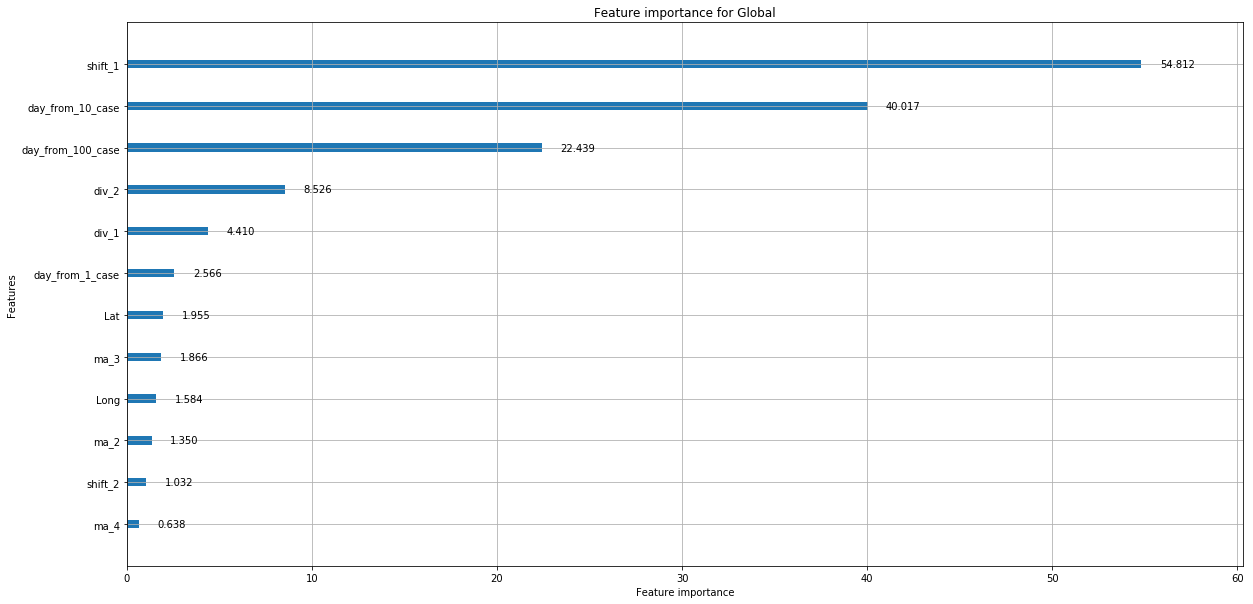

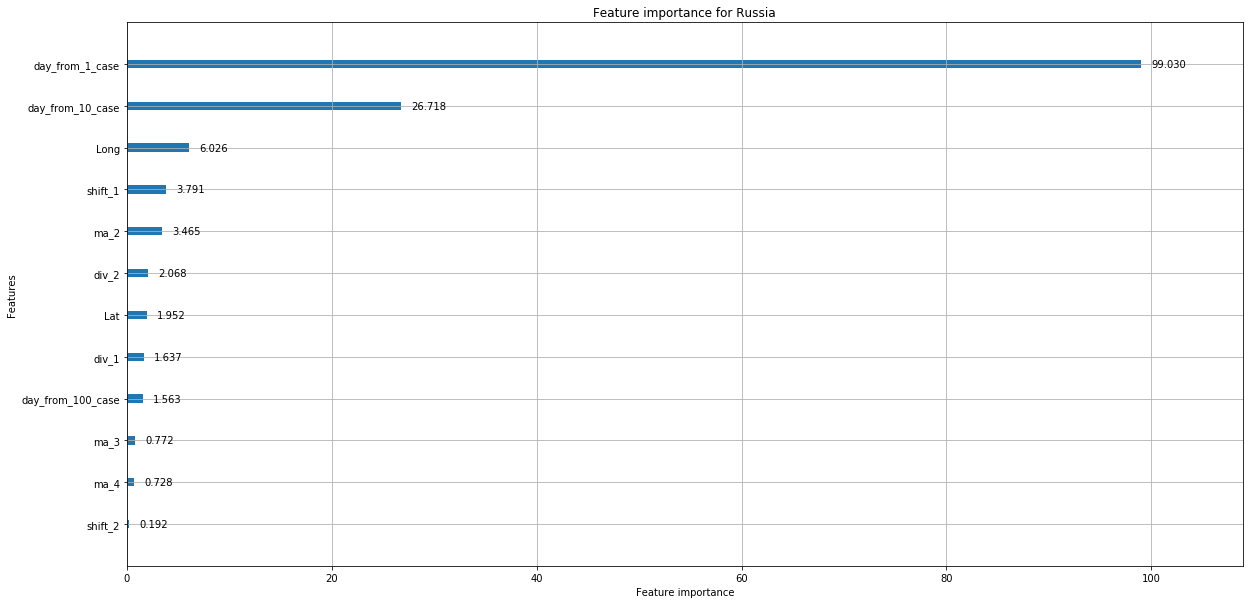

In [12]:
# название колонки с таргетом и параметру lgb
target = 'target'
param_lgb = {'boosting_type': 'gbdt', 'objective': 'rmse', 'metric': 'rmse', 'max_depth': 3, 'learning_rate': 0.1}

# датафрейм, куда будем сохранять наши придсказания
lgb_pred_df = pd.DataFrame()

# считаем кол-во дней, необходимое предсказать
delta_days = (pd.to_datetime(end_test) - pd.to_datetime(end_validation)).days + 1
for day_predict in range( 1,  delta_days):

    lgb_day_pred_global = lgb_compute(start_validation, end_validation, day_predict, target, 0)
    lgb_day_pred_russia = lgb_compute(start_validation, end_validation, day_predict, target, 1)    
    lgb_pred_df = pd.concat([lgb_pred_df, lgb_day_pred_global, lgb_day_pred_russia]).reset_index(drop = True)

# добавляем в семпл сабмишен наши предикты
sample_sub = sample_sub.drop(['real', 'prediction_lgb'], axis=1, errors='ignore')
sample_sub = sample_sub.merge(lgb_pred_df, on = ['region', 'date'], how = 'left')

## Sigmoid и Simple модель
### Sigmoid : с помощью scipy optimize ищем параметры функции $\frac{y_{max}}{1 + \exp^{-k (x - x_0)}}$, для каждой страны
### Simple: считаем значение $\delta = \frac{vals[-1] - vals[-4]}{2}$ и предсказание на $n$ день равно $vals[-1] * n\delta$, где $vals$ это доступные нам данные для определенного региона, данная модель не плохо работала на конкурсе по предсказанию заболевших от вируса от Kaggle

In [13]:
# Simple модель
def simple_compute(data, country, end_train_index, time_range_predict):
    #  данные для обучения
    country_data = data[data['iso2']==country].values[0][11:end_train_index]
    #  считаем дельту
    diff_vals = (country_data[-1] - country_data[-4] ) / 2
    len_predict = len(time_range_predict)
    answer = np.ones(len_predict)
    start_val = country_data[-1]
    #  на каждом шаге добавляем дельту
    for i in range(len_predict):
        start_val += diff_vals
        answer[i] = start_val
    #  сохраняем ответы в датафрейме
    answer_df = pd.DataFrame()
    answer_df['date'] = pd.to_datetime(time_range_predict)
    answer_df['region'] = country
    answer_df['prediction_simple'] = answer 
    return answer_df
# Sigmoid модель
def sigmoid_compute(data, country, end_train_index, time_range_predict, bound_0 = 0.2, bound_1 = 30):
    #  данные для обучения
    country_data = data[data['iso2']==country].values[0][11:end_train_index]
    # если зараженных больше 100, то смотрим с 10 больного иначе с первого
    if country_data.max() > 100:
        start_train_index = np.where(country_data >= 10)[0][0]
    elif country_data.max() >= 1:
        start_train_index = np.where(country_data >= 1)[0][0]
    else:
        start_train_index = len(country_data)
        
    country_data = country_data[start_train_index:]

    x_data = np.arange(len(country_data))
    y_data = np.array(country_data, dtype = float)

    # если нет больных то предсказываем стандартные значения
    if len(x_data) <= 1:
        popt = [ bound_0, bound_1, 100]
    # иначе используем scipy optimize
    else:
        y_max = y_data[-1] * 10
        y_min = y_data[-1]

        popt, pcov = curve_fit(log_curve, x_data, y_data, bounds=([bound_0 - 0.1, bound_1 - 15 , y_min],
                                                                  [bound_0 + 0.1, bound_1 + 15, y_max]), 
                            p0=[bound_0, bound_1 ,(y_min + y_max) / 2], maxfev=100000)
    # предсказываем значения на тест   
    y_val = np.arange(len(x_data), len(x_data) + len(time_range_predict) )
    predict = log_curve(y_val, popt[0], popt[1], popt[2])
    #  сохарняем предсказания в датафрейм
    answer_df = pd.DataFrame()
    answer_df['date'] = pd.to_datetime(time_range_predict)
    answer_df['region'] = country
    answer_df['prediction_logit'] = predict
    if len(country_data) > 0 and predict[0] < country_data[-1]:
        answer_df['prediction_logit'] += (country_data[-1] - predict[0])
    return  answer_df
    
# sigmoid
def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0))) 

In [14]:
end_train_index = np.where(pd.to_datetime(confirmed_data.columns[11:]) == end_validation)[0][0] + 11
time_range_predict = pd.Series(pd.date_range(pd.to_datetime(end_validation), '2020-12-31')[1:]).dt.strftime('%m/%d/%y')

logit_predict_df = pd.DataFrame()
simple_predict_df = pd.DataFrame()
# для каждого региона обучаем 2 модельки и сохраняем предсказания
for country in tqdm(confirmed_data['iso2'].unique()):

    logit_country_predict = sigmoid_compute(confirmed_data, country, end_train_index, time_range_predict)
    logit_predict_df = pd.concat([logit_predict_df, logit_country_predict]).reset_index(drop = True)

    simple_country_predict = simple_compute(confirmed_data, country, end_train_index, time_range_predict)
    simple_predict_df = pd.concat([simple_predict_df, simple_country_predict]).reset_index(drop = True)
    
# добавляем наши предсказания в  sample_submission
sample_sub = sample_sub.drop(['prediction_logit'], axis=1, errors='ignore')
sample_sub = sample_sub.merge(logit_predict_df, on = ['region', 'date'], how = 'left')

sample_sub = sample_sub.drop(['prediction_simple'], axis=1, errors='ignore')
sample_sub = sample_sub.merge(simple_predict_df, on = ['region', 'date'], how = 'left')

## Графики
### проверим как отрабатывают модели на первой недели соревнования

LightGBM 0.4375499597864707
Simple 0.46932159642395754
Sigmoid 0.5614415995023206
Average 0.42580057643669306


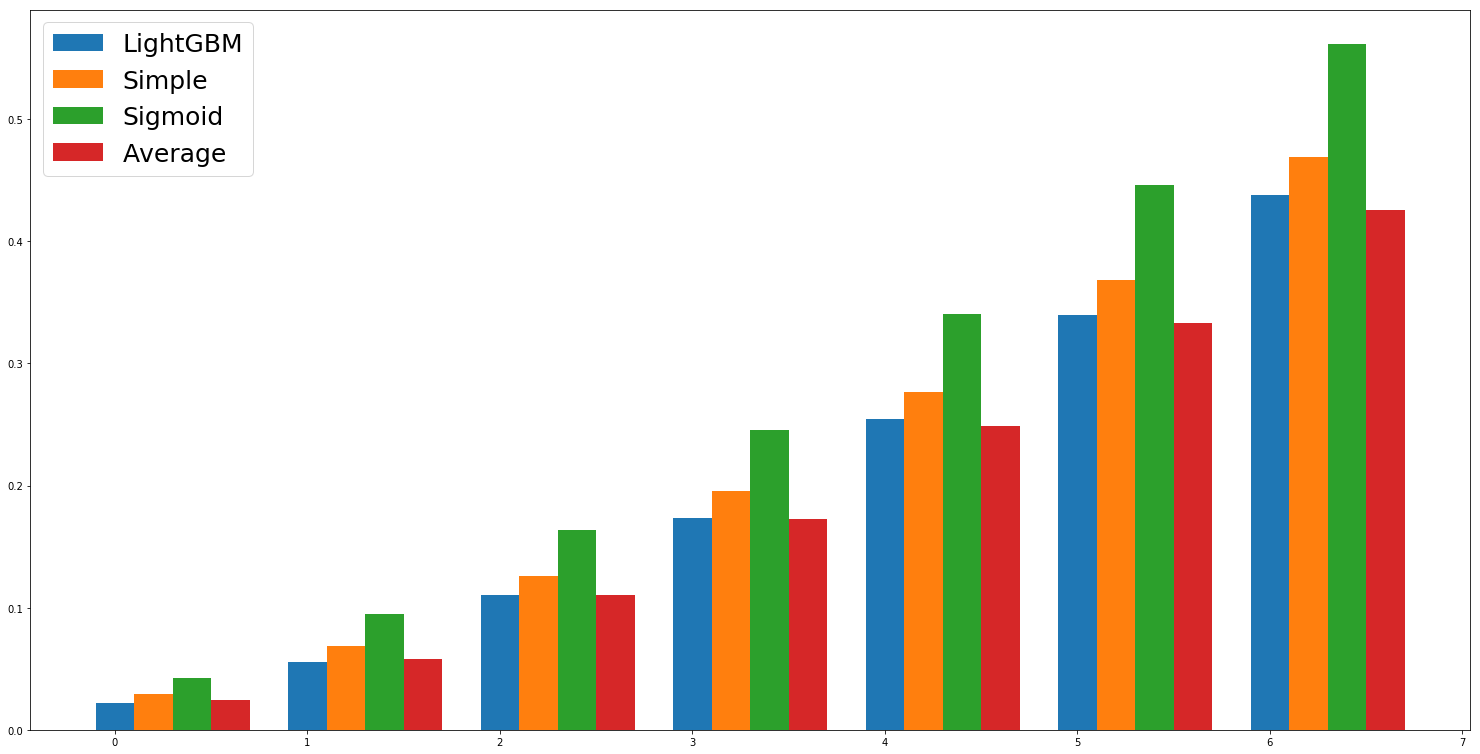

In [15]:
validation_sample_sub = sample_sub[(sample_sub.date > end_validation) & (sample_sub.date <= end_test) ].copy()
validation_sample_sub['check'] = [1 if 'RU-' in x or 'UA-' in x else 0 for x in validation_sample_sub.region.tolist()]
labels = ['LightGBM', 'Simple', 'Sigmoid', 'Average']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# считаем кумалитивные суммы ошибок (то что отображается на лб), по 3 моделькам отдельно и их усреднению

for j, k_list in enumerate([[1, 0 , 0], [0, 1, 0], [0, 0, 1], [0.45, 0.45, 0.1]]):
    score_list = []

    for i, date in enumerate(sorted(validation_sample_sub.date.unique())):

        tmp_validation_sample_sub = validation_sample_sub[(validation_sample_sub.date == date) & 
                                                         (validation_sample_sub.check == 0)]
        real = tmp_validation_sample_sub['real']
        predict = (tmp_validation_sample_sub['prediction_lgb'] * k_list[0]  + 
                   tmp_validation_sample_sub['prediction_simple'] * k_list[1] + 
                   tmp_validation_sample_sub['prediction_logit'] * k_list[2] )

        predict = predict.astype('int')
        score_list += [male(real, predict)]
        
    print(labels[j], np.sum(score_list))    
    score_list = np.cumsum(score_list)
    plt_dates = np.arange(len(score_list), dtype = float)
    ax.bar(plt_dates + j * 0.2, score_list, width = 0.2)

ax.legend(labels=labels, prop={'size': 25})
plt.show()

### простая моделька дает результат в районе топ 10, lgb в районе топ 7

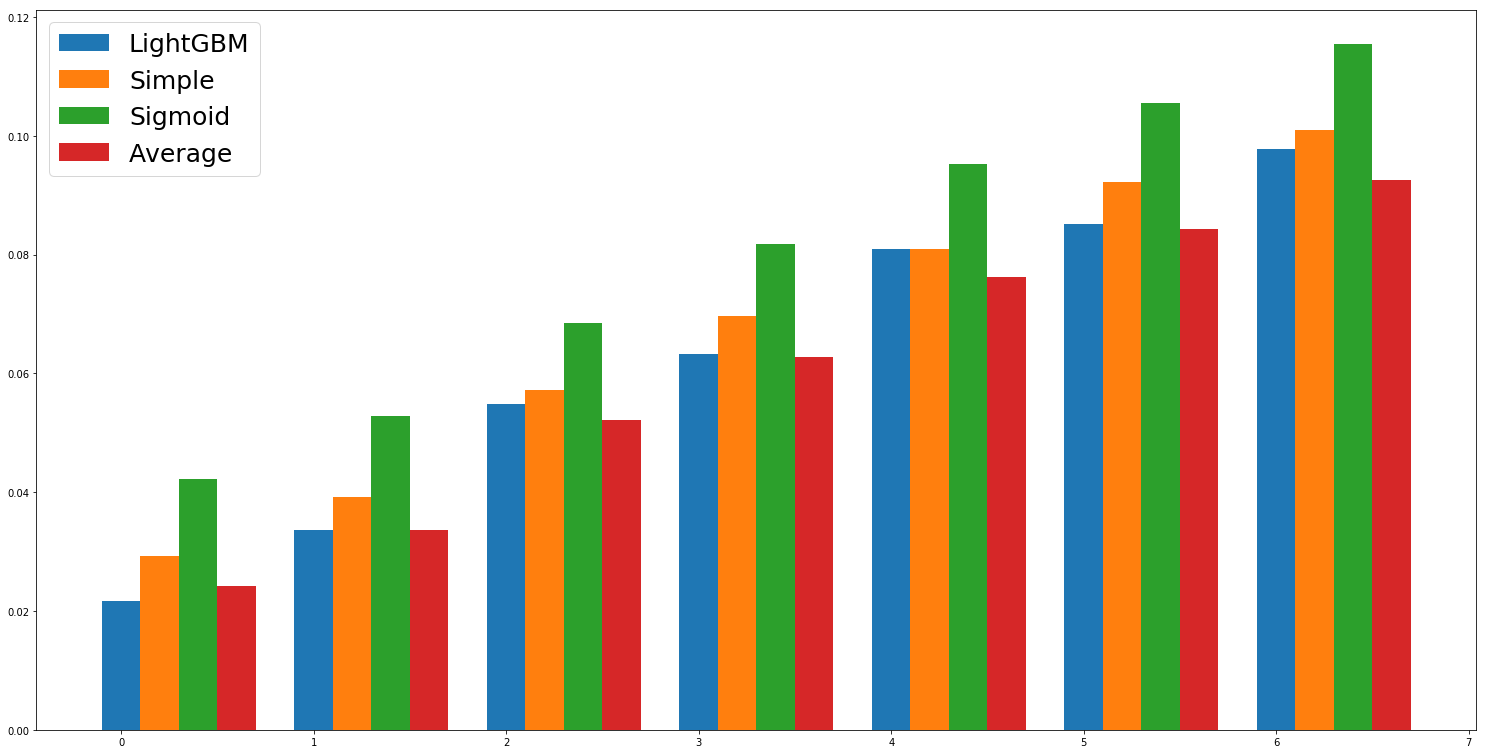

In [16]:
validation_sample_sub = sample_sub[(sample_sub.date > end_validation) & (sample_sub.date <= end_test) ].copy()
validation_sample_sub['check'] = [1 if 'RU-' in x or 'UA-' in x else 0 for x in validation_sample_sub.region.tolist()]
labels = ['LightGBM', 'Simple', 'Sigmoid', 'Average']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# считаем ошибки по каждому дню, по 3 моделькам отдельно и их усреднению

for j, k_list in enumerate([[1, 0 , 0], [0, 1, 0], [0, 0, 1], [0.45, 0.45, 0.1]]):
    score_list = []

    for i, date in enumerate(sorted(validation_sample_sub.date.unique())):

        tmp_validation_sample_sub = validation_sample_sub[(validation_sample_sub.date == date) & 
                                                         (validation_sample_sub.check == 0)]
        real = tmp_validation_sample_sub['real']
        predict = (tmp_validation_sample_sub['prediction_lgb'] * k_list[0]  + 
                   tmp_validation_sample_sub['prediction_simple'] * k_list[1] + 
                   tmp_validation_sample_sub['prediction_logit'] * k_list[2] )

        predict = predict.astype('int')
        score_list += [male(real, predict)]
        
    plt_dates = np.arange(len(score_list), dtype = float)
    ax.bar(plt_dates + j * 0.2, score_list, width = 0.2)

ax.legend(labels=labels, prop={'size': 25})
plt.show()

### Можно увидеть, что lighgbm сильно лучше отрабатывают только на первых двух днях, потом сравнивается с результатами простой модели, усреднение дает результат чуть по лучше

### Сгенерируем итоговый ответ

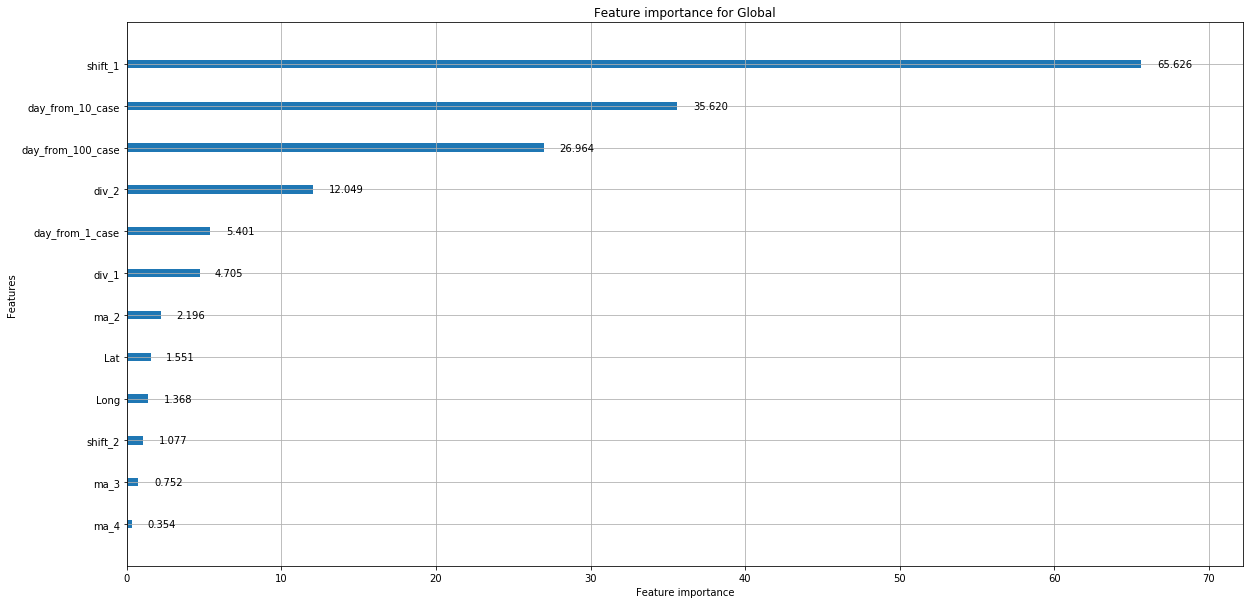

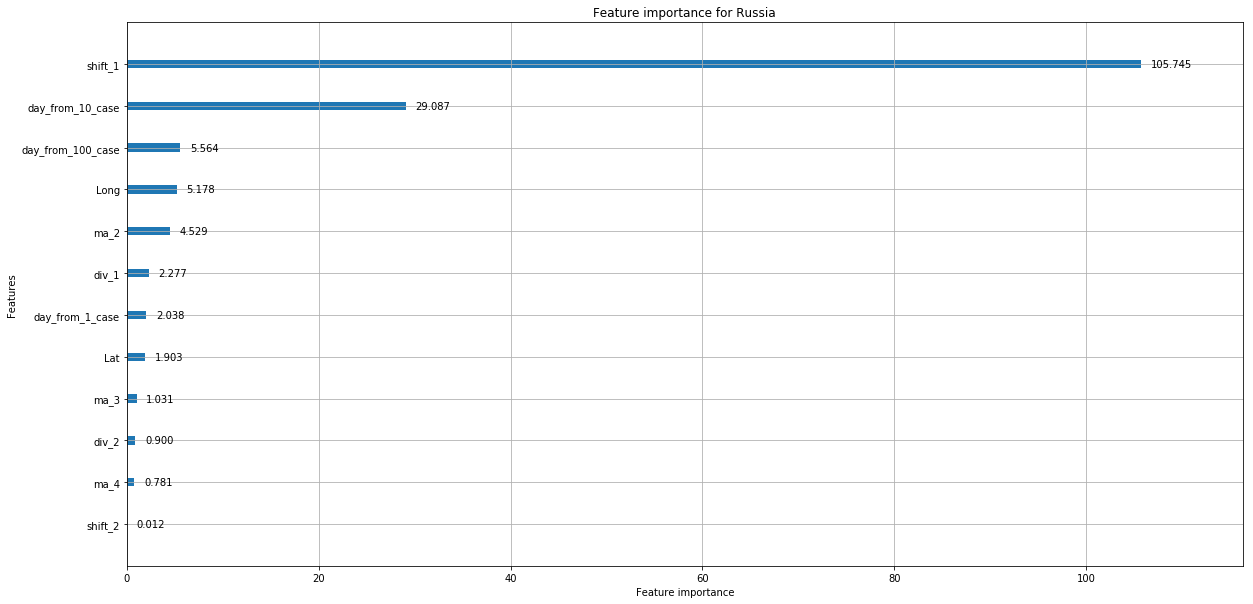

In [17]:
start_validation = '2020-04-21'
# последние доступные данные
end_validation = '2020-04-22'
end_test = '2020-05-03'


# датафрейм, куда будем сохранять наши придсказания
lgb_pred_df = pd.DataFrame()

# считаем кол-во дней, необходимое предсказать
delta_days = (pd.to_datetime(end_test) - pd.to_datetime(end_validation)).days + 1
for day_predict in range( 1,  delta_days):

    lgb_day_pred_global = lgb_compute(start_validation, end_validation, day_predict, target, 0)
    lgb_day_pred_russia = lgb_compute(start_validation, end_validation, day_predict, target, 1)    
    lgb_pred_df = pd.concat([lgb_pred_df, lgb_day_pred_global, lgb_day_pred_russia]).reset_index(drop = True)

# добавляем в семпл сабмишен наши предикты
sample_sub = sample_sub.drop(['real', 'prediction_lgb'], axis=1, errors='ignore')
sample_sub = sample_sub.merge(lgb_pred_df, on = ['region', 'date'], how = 'left')

In [18]:
end_train_index = np.where(pd.to_datetime(confirmed_data.columns[11:]) == end_validation)[0][0] + 11
time_range_predict = pd.Series(pd.date_range(pd.to_datetime(end_validation), '2020-12-31')[1:]).dt.strftime('%m/%d/%y')

logit_predict_df = pd.DataFrame()
simple_predict_df = pd.DataFrame()
# для каждого региона обучаем 2 модельки и сохраняем предсказания
for country in tqdm(confirmed_data['iso2'].unique()):

    logit_country_predict = sigmoid_compute(confirmed_data, country, end_train_index, time_range_predict)
    logit_predict_df = pd.concat([logit_predict_df, logit_country_predict]).reset_index(drop = True)

    simple_country_predict = simple_compute(confirmed_data, country, end_train_index, time_range_predict)
    simple_predict_df = pd.concat([simple_predict_df, simple_country_predict]).reset_index(drop = True)
    
# добавляем наши предсказания в  sample_submission
sample_sub = sample_sub.drop(['prediction_logit'], axis=1, errors='ignore')
sample_sub = sample_sub.merge(logit_predict_df, on = ['region', 'date'], how = 'left')

sample_sub = sample_sub.drop(['prediction_simple'], axis=1, errors='ignore')
sample_sub = sample_sub.merge(simple_predict_df, on = ['region', 'date'], how = 'left')

In [19]:
# где есть предсказания lgb , усредняем 3 модельки
test_index_lgb = sample_sub.prediction_lgb.isnull()
sample_sub.loc[~test_index_lgb , 'prediction_confirmed']  = (sample_sub.loc[~test_index_lgb , 'prediction_lgb'] * 0.45 + 
    sample_sub.loc[~test_index_lgb , 'prediction_simple'] * 0.45 + sample_sub.loc[~test_index_lgb , 'prediction_logit'] * 0.1)
# иначе усредняем 2 оставшиеся
test_index_other = sample_sub.prediction_lgb.isnull() & (~ sample_sub.prediction_logit.isnull())
sample_sub.loc[test_index_other , 'prediction_confirmed']  = (sample_sub.loc[test_index_other , 'prediction_simple'] * 0.5 +
                                                         sample_sub.loc[test_index_other , 'prediction_logit'] * 0.5)

In [20]:
sample_sub['prediction_confirmed'] = sample_sub['prediction_confirmed'].astype('int')
sample_sub[sample_sub.date >= '2020-04-14'][['date','region', 'prediction_confirmed', 
                                             'prediction_deaths']].to_csv('answer.csv', index = None )

# КОНЕЦ!!! СПАСИБА!!! ДО СКОРЫХ ВСТРЕЧ!!!